# Protective Layers Against Targeted E-Mail (PlateMail)

## Table of Contents

* [Introduction](#introduction)
* [Initial Example](#initial-example)
* [Loading Data](#loading-data)
* [Initial Metrics](#initial-metrics)
* [Metrics After Novel Attack](#metrics-after-novel-attack)
* [Updated Intents](#updated-intents)
* [Results](#results)

## Introduction
PlateMail is designed to leverage generative AI for training against spear phishing emails. See this [blog](https://developer.nvidia.com/blog/generative-ai-and-accelerated-computing-for-spear-phishing-detection/) for a more detailed overview.

## Initial example
The following example uses just 2 intents (asking for money and asking for PII) for training. A classifier will be trained and then a novel attack will be introduced (crypto based scams).

In [ ]:
import os
import sys
import datetime

platemail_path = os.path.abspath('../')
if platemail_path not in sys.path:
    sys.path.append(platemail_path)
from platemail.platemail import process_email

import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

## Loading data

In [3]:
dataset_train = pd.read_csv('../datasets/train/20231024_example_train.csv')
dataset_test = pd.read_csv('../datasets/test/20231024_example_test.csv')

## Loading and parsing emails
The run_platemail function parses out the training and test data that have been saved as DataFrames into a collection of emails, intents, and metadata for each set.

In [4]:
def run_platemail(df):
    parsed = df.to_dict('records')
    for entry in parsed:
        entry['arrival_time'] = datetime.datetime.fromisoformat(str(entry['arrival_time']))
        entry['intents'] = eval(str(entry['intents']))
        entry.update(process_email(entry))
    return parsed

In [5]:
parsed_train = run_platemail(dataset_train)

In [6]:
parsed_test = run_platemail(dataset_test)

## Vectorizing emails
Next we convert our sets into vectors for the classifier training and metrics gathering. A filter to handle the crypto intent has been added, so that we can see how the approach can be adapted to a novel attack.

In [43]:
def vectorize(parsed_data, crypto_intent, filter_crypto):
    X = []
    y = []
    for entry in parsed_data:
        if entry['source'] == 'crypto' and filter_crypto:
            continue
        vector = []
        for intent, results in entry['intents'].items():
            if intent != 'crypto' or crypto_intent:
                vector.append(results['id'])
        vector.append(entry['new_intent'])
        vector.append(entry['syntax_sim'])
        vector.append(entry['time_liklihood'])
        X.append(vector)
        y.append(entry['label'])
    return X, y

In [8]:
label_encoder = {'benign': 0, 'phish': 1}
label_decoder = {0:'benign', 1:'phish'}

## Initial Model Training
A simple logistic regression is trained, but only on the money and PII intents.

In [37]:
no_crypto_model = LogisticRegression(random_state=23)

Vectorizing just the training set without any crypto intents or emails.

In [44]:
X_train_no_crypto, Y_train_no_crypto = vectorize(parsed_train, crypto_intent=False, filter_crypto=True)

We vectorize the test sets with and without the crypto attacks.

In [46]:
X_test_no_crypto, Y_test_no_crypto = vectorize(parsed_test, crypto_intent=False, filter_crypto=True)
X_test_w_crypto, Y_test_w_crypto = vectorize(parsed_test, crypto_intent=False, filter_crypto=False)

In [47]:
no_crypto_model.fit(X_train_no_crypto, Y_train_no_crypto)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,23
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## Initial Metrics

Text(0.5, 1.0, 'Phishing Classifier - No Crypto Emails')

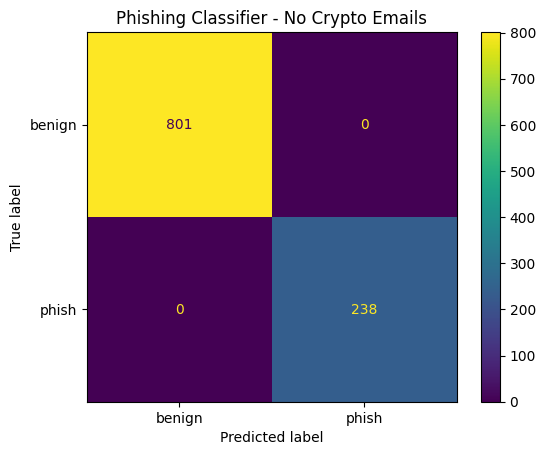

In [48]:
disp = ConfusionMatrixDisplay.from_predictions(Y_test_no_crypto, no_crypto_model.predict(X_test_no_crypto))
disp.ax_.set_title('Phishing Classifier - No Crypto Emails')

We see perfect prediction for these two intents.

## Metrics After Novel Attack
This represents the model detecting a completely novel attack. It is unable to defend against the new attack, but with just a few examples; generative AI can create a training set of this new attack and this new intent can be trained against.

Text(0.5, 1.0, 'Phishing Classifier - Crypto Emails Introduced')

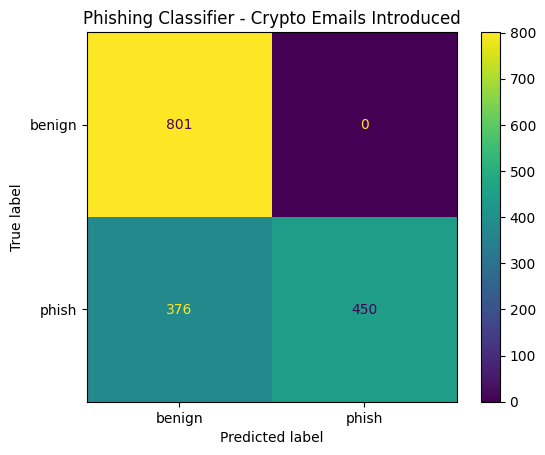

In [49]:
disp = ConfusionMatrixDisplay.from_predictions(Y_test_w_crypto, no_crypto_model.predict(X_test_w_crypto))
disp.ax_.set_title('Phishing Classifier - Crypto Emails Introduced')

We see that the current model managed to catch 212 of the cyrpto test emails, but missed 376.

## Updated Intents
After generating a dataset for the new attack and training the intent, the training set is augmented with examples of this crypto attack.

In [54]:
crypto_model = LogisticRegression(random_state=24)

We vectorize the training with the new crypto attack and train a new classifier.

In [55]:
X_train_w_crypto, Y_train_w_crypto = vectorize(parsed_train, crypto_intent=True, filter_crypto=False)

In [56]:
crypto_model.fit(X_train_w_crypto, Y_train_w_crypto)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,24
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [57]:
X_test_w_crypto, Y_test_w_crypto = vectorize(parsed_test, crypto_intent=True, filter_crypto=False)

## Results

Text(0.5, 1.0, 'Phishing Classifier - Crypto Emails Trained')

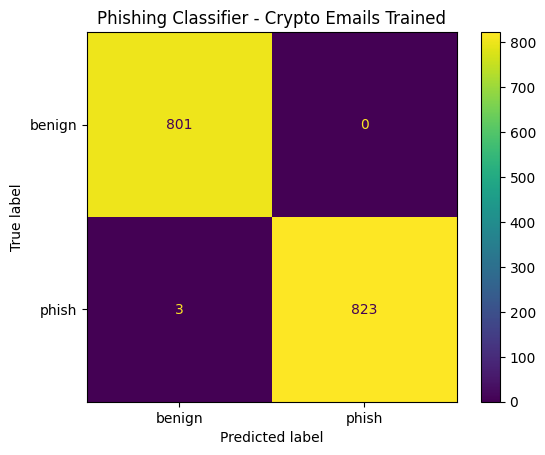

In [59]:
disp = ConfusionMatrixDisplay.from_predictions(Y_test_w_crypto, crypto_model.predict(X_test_w_crypto))
disp.ax_.set_title('Phishing Classifier - Crypto Emails Trained')

This updated model with the same test set has reduced the uncaught emails from 376 to 3.

## Conclusion

With the new intent, the novel attack is successfully detected. Identifying an attack, tuning a generative model, and learning a new intent classifier can all be done rapidly to fight emerging scams.